## 1.0 Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
import time
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.mixture import GaussianMixture

## 2.0 Leitura da base de dados

In [2]:
df_churn = pd.read_csv('../db_churn_2.csv')
df_churn = df_churn.drop(columns='Unnamed: 0')
df_churn.head()

,ClientId,DataExtracao,Score_Credito,Estado,Gênero,Idade,Tempo_Cliente,Limite_Credito_Mercado,Qte_Categorias,Usa_Cartao_Credito,Programa_Fidelidade,Sum_Pedidos_Acumulados,DataUltimaTransacao,DiasDesdeUltTransacao,Target
0,345568,2019-06-30,619,São Paulo,Feminino,42,2,0.0000,1,1,1,422.287000,2019-09-14,46,1
1,345569,2019-06-30,608,Rio de Janeiro,Feminino,41,1,838.0786,1,0,1,468.927417,2019-10-05,25,0
2,345570,2019-06-30,502,São Paulo,Feminino,42,8,1596.6080,3,1,0,474.714875,2019-08-20,71,1
3,345571,2019-06-30,699,São Paulo,Feminino,39,1,0.0000,2,0,0,390.944292,2019-10-21,9,0
4,345572,2019-06-30,850,Rio de Janeiro,Feminino,43,2,1255.1082,1,1,1,329.517083,2019-10-26,4,0


## 3.0 Preparação dos Dados

### 3.1 Enconding

In [3]:
X = df_churn.drop(columns=['ClientId', 'DataExtracao', 'DataUltimaTransacao', 'DiasDesdeUltTransacao','Target'])

cat_attributes = X.select_dtypes(include='object')
num_attributes = X.select_dtypes(exclude='object')

# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

# Define numerical pipeline with RobustScaler
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_attributes.columns),
    ('num', num_pipe, num_attributes.columns)
])

pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# Aplica o pipeline à base de dados
X_processed = pipeline.fit_transform(X)

# Obtém os nomes das colunas após o one-hot encoding
encoded_cat_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']\
    .get_feature_names_out(input_features=cat_attributes.columns)

# Combina os nomes das colunas categóricas codificadas e as colunas numéricas
all_columns = list(encoded_cat_columns) + list(num_attributes.columns)

# Cria um DataFrame com as colunas pré-processadas e seus nomes
df_X_processed = pd.DataFrame(X_processed, columns=all_columns)

### 3.2 Redução de Dimensionalidade

In [4]:
df_X_processed.shape

(10000, 11)

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.90)
pca.fit(df_X_processed)
df_reduced = pca.transform(df_X_processed)
df_reduced.shape

(10000, 9)

## 4.0 Modelagem

### 4.1 Clusterização

#### 4.1.1 K-Means

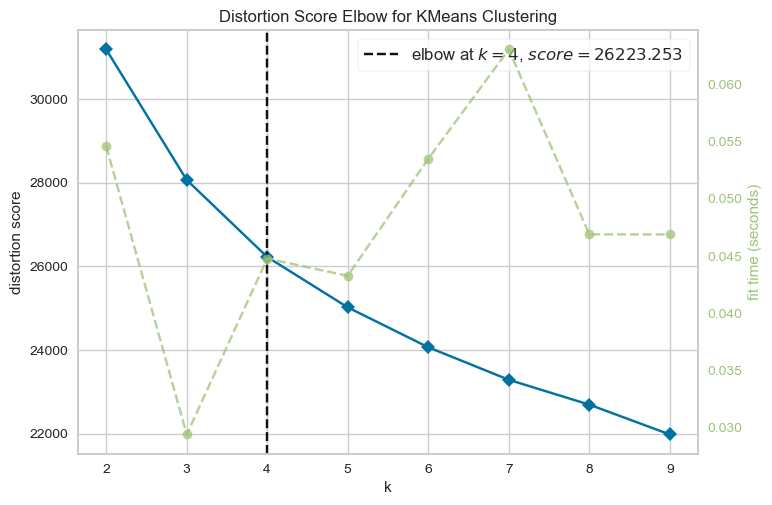

In [23]:
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state=0, n_init='auto')
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,10), timings= True);
visualizer.fit(df_reduced)        # Fit data to visualizer
visualizer.show();        # Finalize and render figure

#### 4.1.2 Treino do Modelo K-means

In [24]:
# Treinar o algoritmo K-means com 4 clusters
kmeans = KMeans(n_clusters=4, random_state=0, n_init='auto')
kmeans.fit(df_reduced)

# Obter os centróides dos clusters
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

df_churn['Cluster'] = labels

np.unique(labels)

array([0, 1, 2, 3])

#### 4.1.1 Mistura Gaussiana

In [8]:
n_components = range(1, 10)
covariance_type = ['spherical', 'tied', 'diag', 'full']
best_bic = float('inf')  # Inicialize com um valor infinito
best_config = None
bic_scores = []

for cov in covariance_type:
    for n_comp in n_components:
        gmm = GaussianMixture(n_components=n_comp, covariance_type=cov, random_state=0)
        gmm.fit(df_reduced)
        bic_score = gmm.bic(df_reduced)
        bic_scores.append((cov, n_comp, bic_score))

        if bic_score < best_bic:
            best_bic = bic_score
            best_config = (cov, n_comp)

print("Melhor configuração:", best_config)
print("Menor BIC:", best_bic)

Melhor configuração: ('full', 7)
Menor BIC: 83920.76868251845


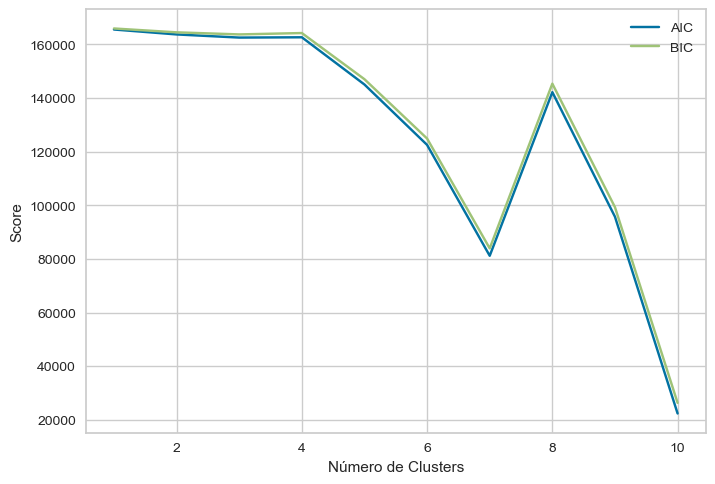

In [9]:
# Lista para armazenar valores de AIC e BIC
aic_scores = []
bic_scores = []

# Testar diferentes números de clusters
for n_clusters in range(1, 11):
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=0)
    gmm.fit(df_reduced)
    aic_scores.append(gmm.aic(df_reduced))
    bic_scores.append(gmm.bic(df_reduced))

# Plotar AIC e BIC em função do número de clusters
import matplotlib.pyplot as plt

plt.plot(range(1, 11), aic_scores, label='AIC')
plt.plot(range(1, 11), bic_scores, label='BIC')
plt.xlabel('Número de Clusters')
plt.ylabel('Score')
plt.legend()
plt.show()

#### 4.1.2 Treino do Modelo Mistura Gaussiana

In [10]:
# Inicializar o modelo de Mistura Gaussiana
gmm = GaussianMixture(n_components=7, covariance_type='full', random_state=0)

# Ajustar o modelo aos dados com parâmetros de inicialização específicos
gmm.fit(df_reduced)

# Prever os rótulos dos clusters
labels = gmm.predict(df_reduced)

df_churn['Cluster'] = labels

labels = np.array([0, 1, 2, 3, 4, 5, 6], dtype=np.int64)
labels = labels.astype(int)

np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6])

#### 4.1.3 Análise dos Clusters Gerados

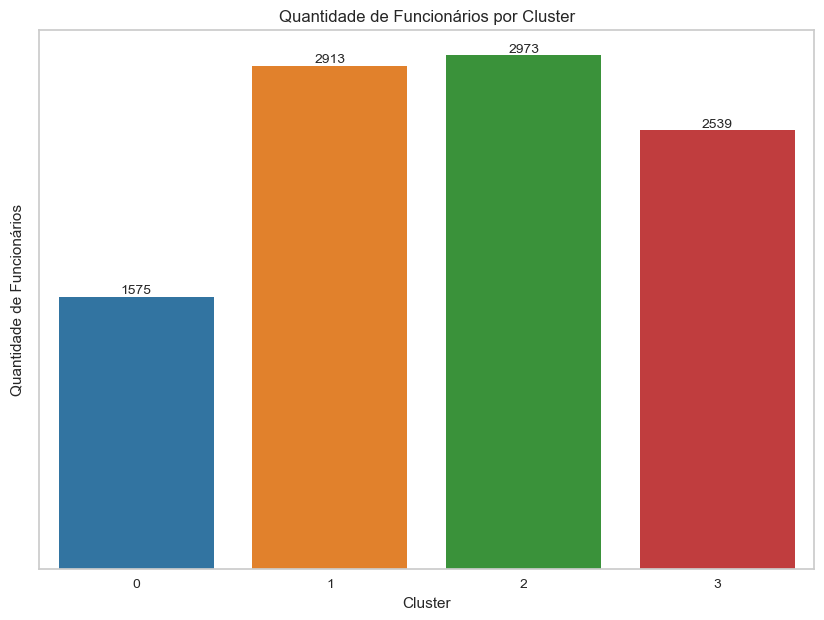

In [25]:
pal = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
pal = pal[:len(np.unique(labels))]

plt.figure(figsize=(10,7))
pl = sns.countplot(data=df_churn, x="Cluster", palette=pal)

for i in range(len(pl.containers)):
  pl.bar_label(pl.containers[i], fontsize=10)
pl.set_title("Quantidade de Funcionários por Cluster")
plt.gca().axes.yaxis.set_ticklabels([])
plt.ylabel('Quantidade de Funcionários')
plt.grid(False)
plt.show()

Nota-se que:
  * O cluster 0 é onde tem menor quantidade de participação, representando 16% do total;
  * O segundo cluster com menor participação é o 3 representando 25,4% do total;

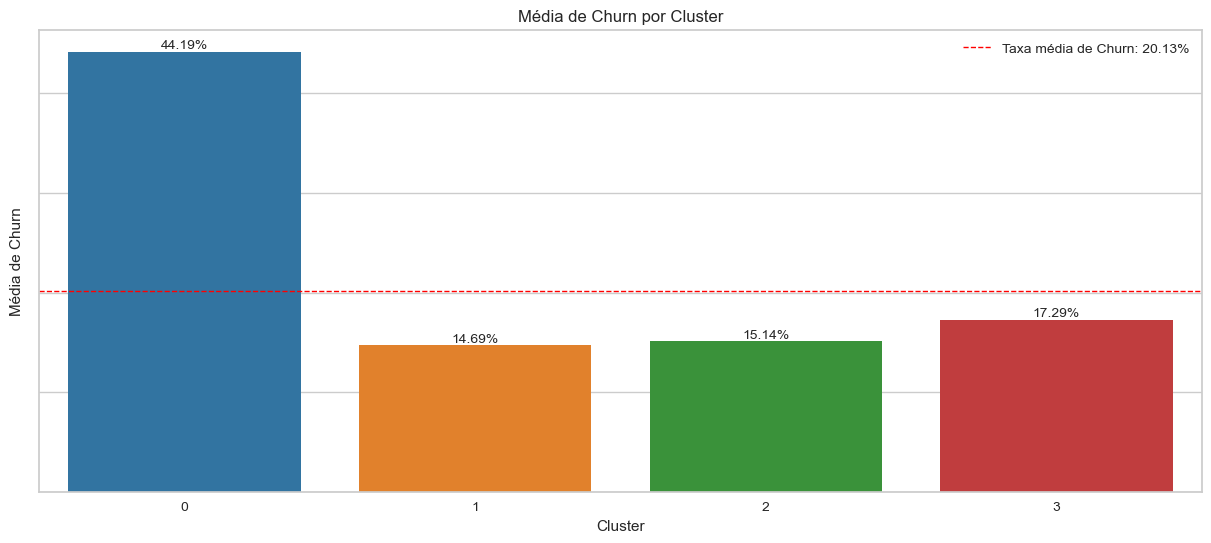

In [26]:
df_churn['TARGET'] = (df_churn['Target'] == 1).astype(int)

# Calcular a média da variável "Rotatividade" para cada cluster
mean_rotatividade_by_cluster = df_churn.groupby("Cluster")["TARGET"].mean().reset_index()

overall_mean_churn = df_churn['TARGET'].mean()

# Plot the barplot
plt.figure(figsize=(15, 6))
sns.barplot(x="Cluster", y="TARGET", data=mean_rotatividade_by_cluster, palette=pal)

# Plot the overall mean churn rate as a dashed line
plt.axhline(overall_mean_churn, color='red', linestyle='dashed', linewidth=1, label='Taxa média de Churn: {:.2f}%'.format(overall_mean_churn * 100))

plt.title("Média de Churn por Cluster")
plt.xlabel("Cluster")
plt.ylabel("Média de Churn")

# Add the churn rate values on the bars
for i, taxa in enumerate(mean_rotatividade_by_cluster.TARGET.values):
    plt.text(i, taxa, '{:.2f}%'.format(taxa * 100), ha='center', va='bottom', fontsize=10)

plt.gca().axes.yaxis.set_ticklabels([])
plt.legend()
plt.show()

Verifica-se que:
 * Os clusters 0 é o que apresentam maior taxa de churn com 44%;
 * Todos os demais clusters apresentam menor taxa de churn em percentual do que a média da empresa;

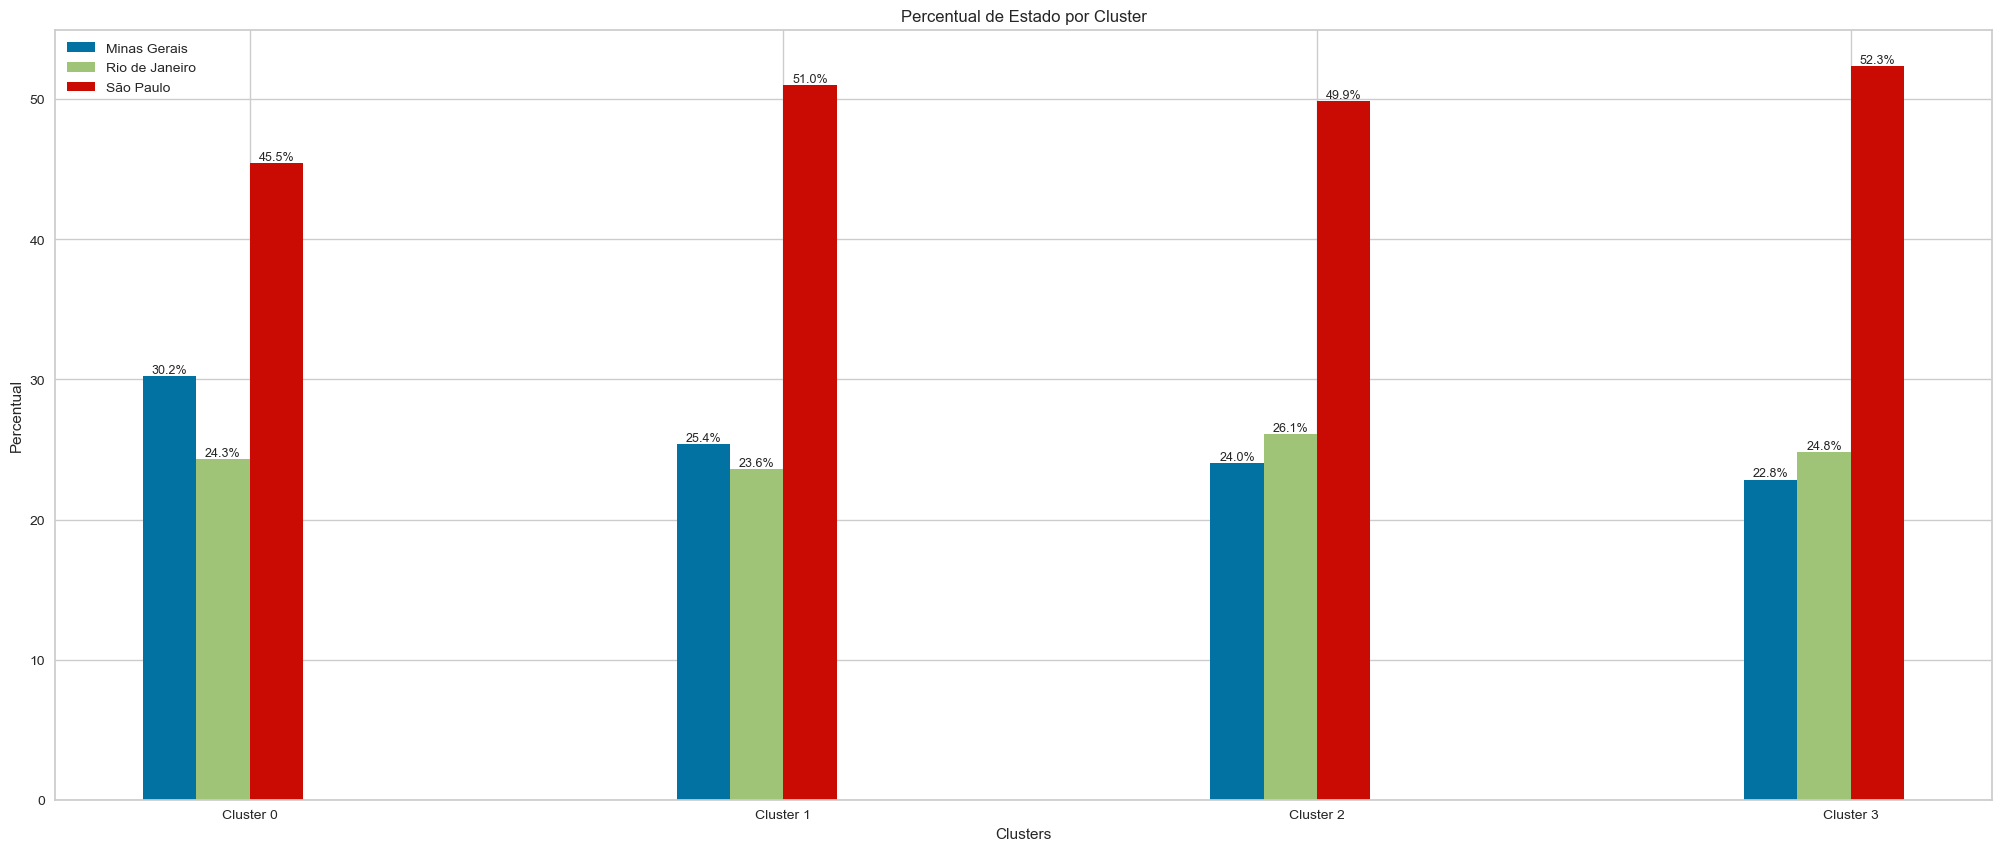

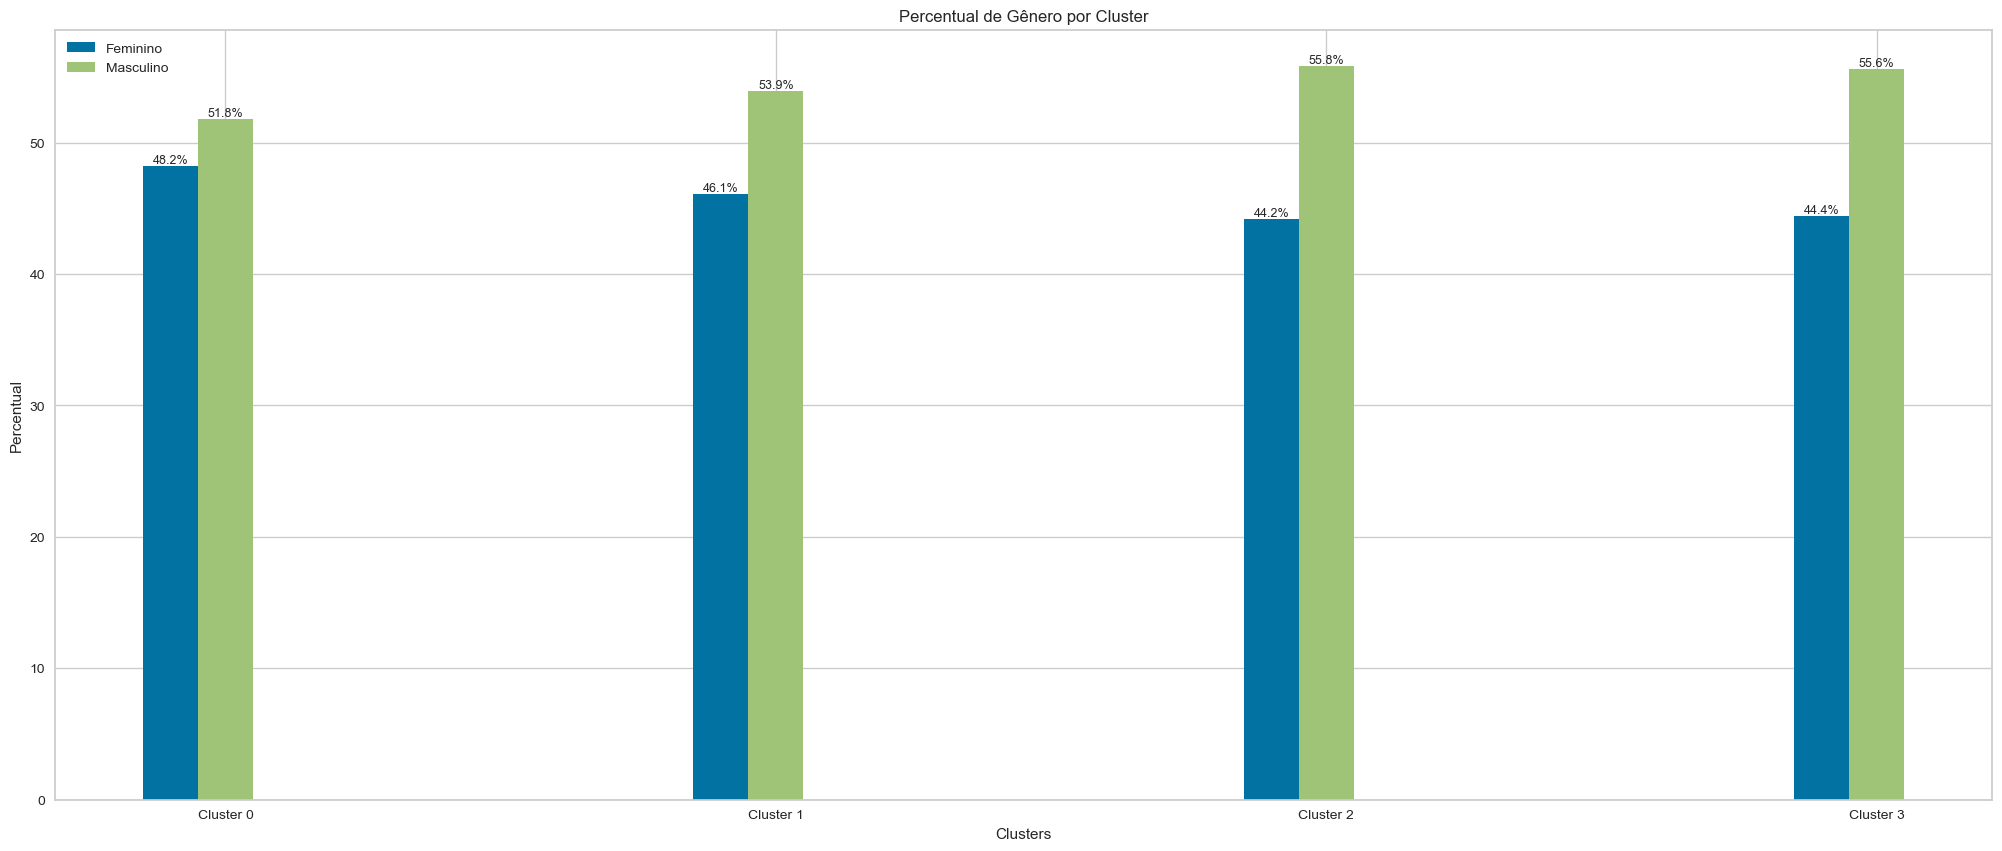

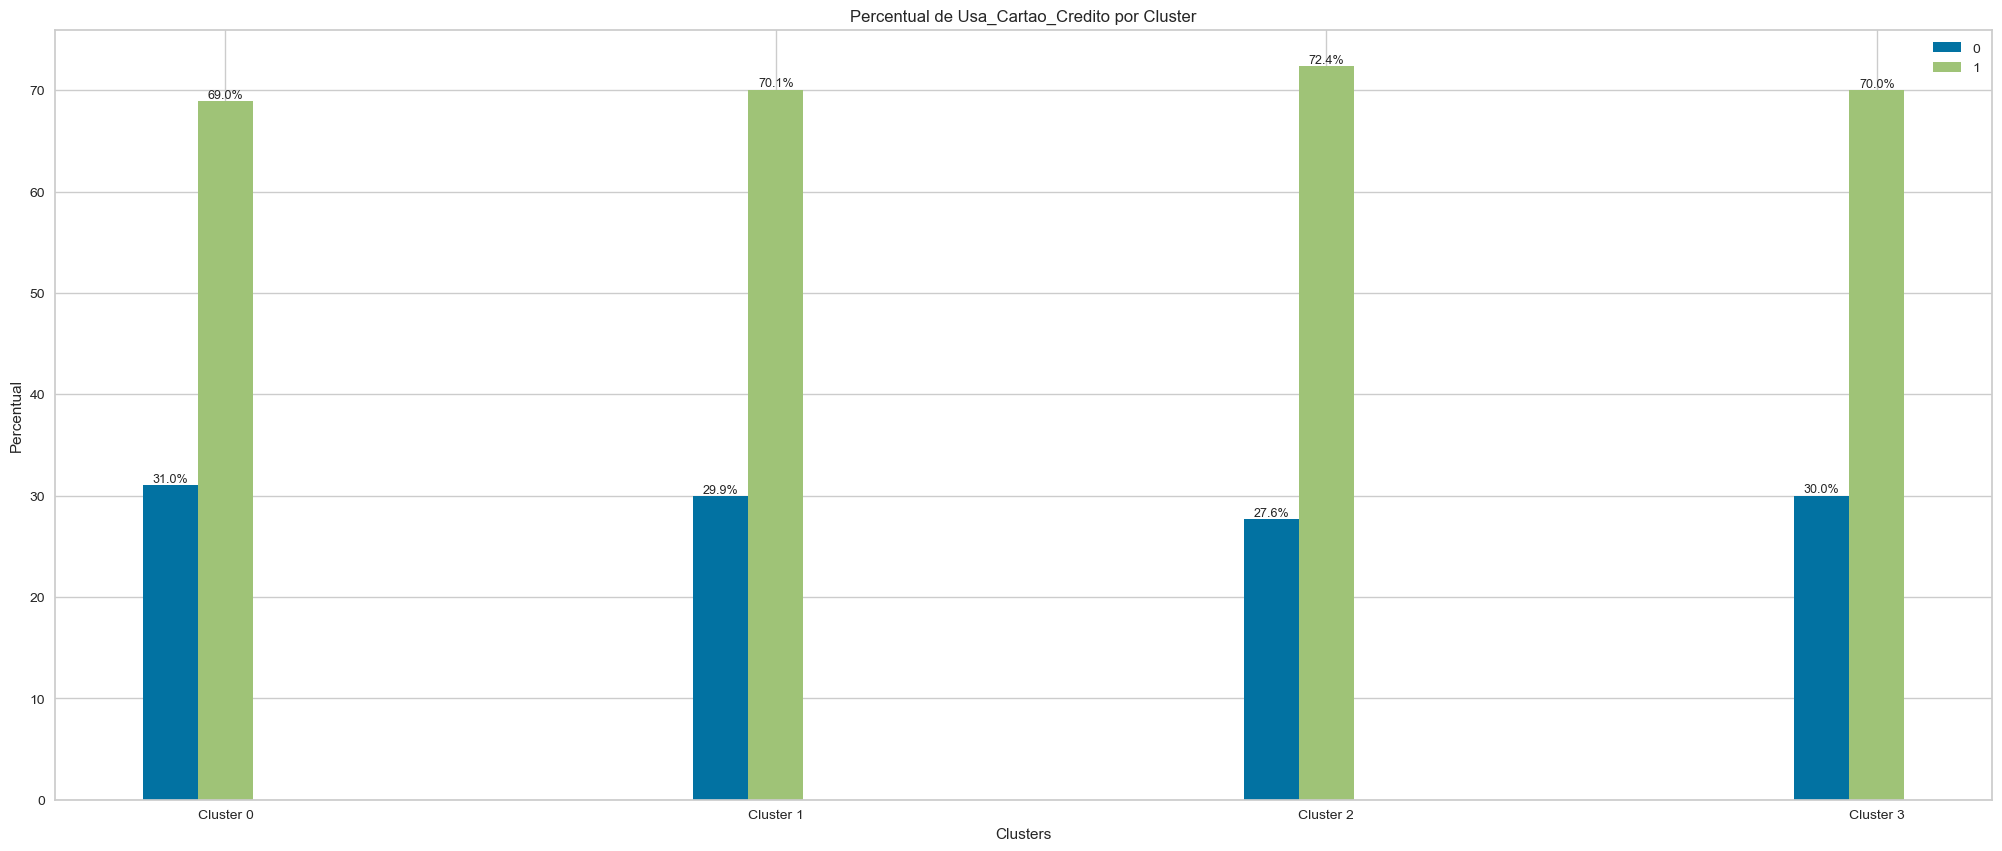

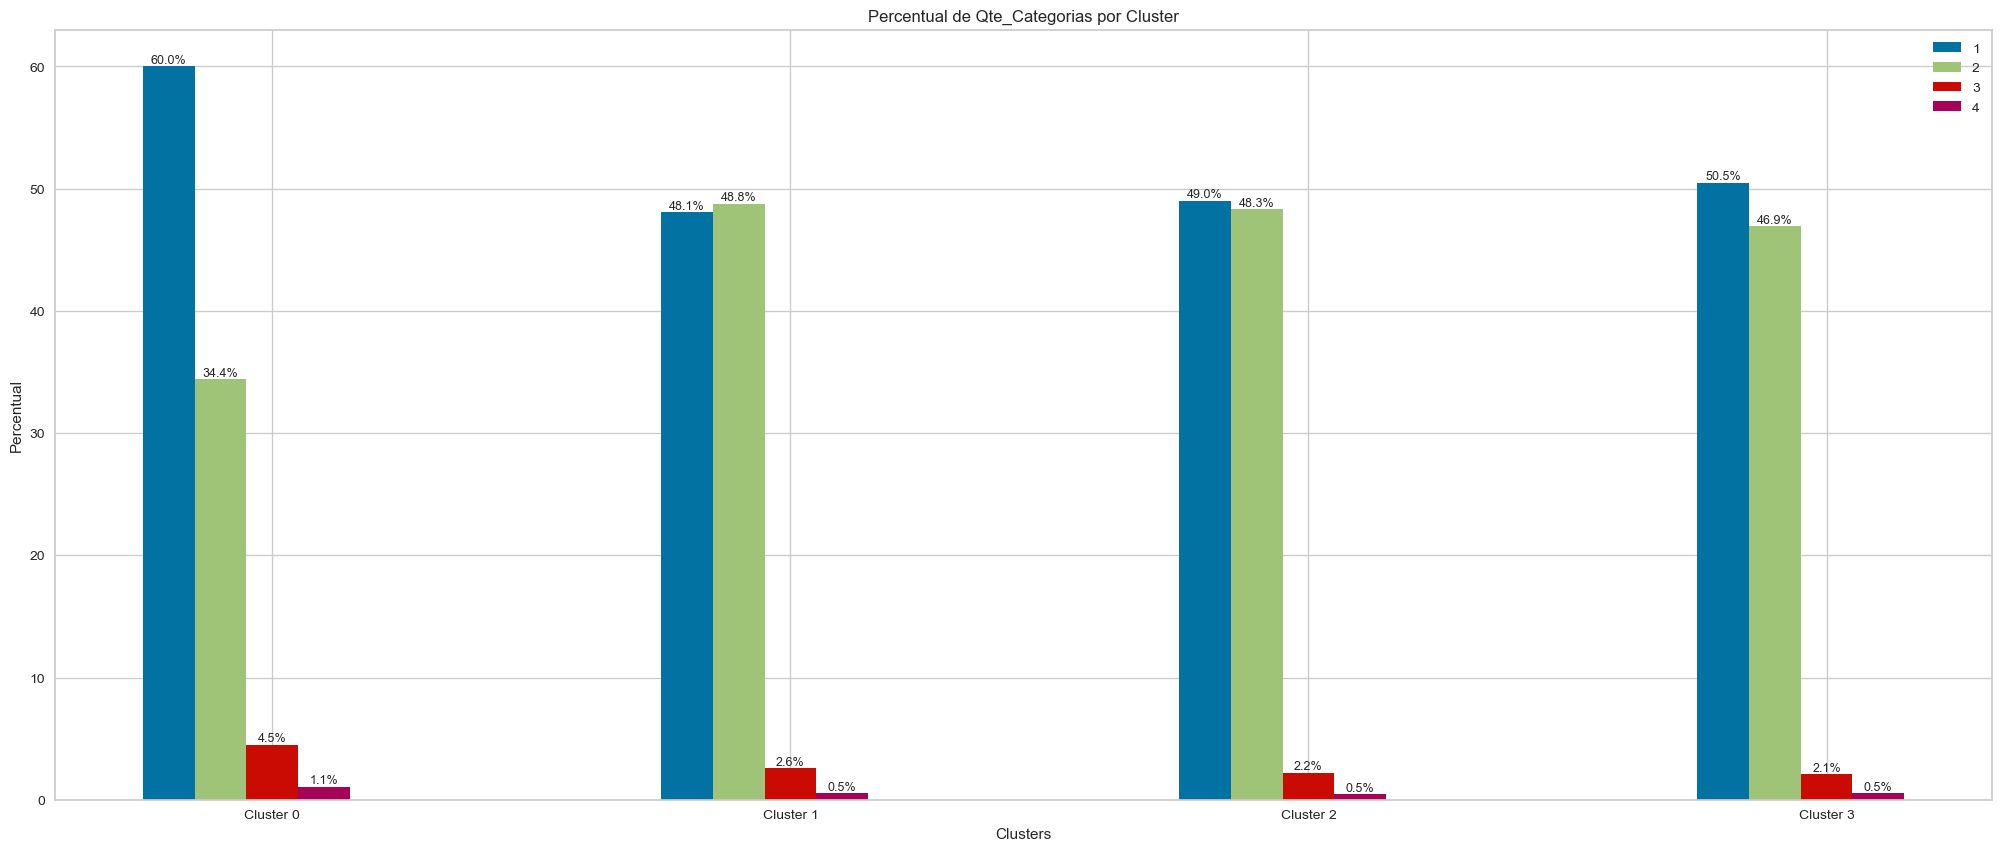

In [27]:
# Variáveis a serem analisadas:
vars1 = list(cat_attributes.columns).copy()
#vars1.remove(['ClientId', 'DataExtracao', 'DataUltimaTransacao', 'DiasDesdeUltTransacao'])
#vars1.remove('ClientId')
#vars1.remove('Target')

vars2 = ['Usa_Cartao_Credito','Qte_Categorias']

vars_categoricas = vars1 + vars2

for var in vars_categoricas:
  percentuais_por_cluster = df_churn.groupby('Cluster')[var].value_counts(normalize=True).mul(100).unstack().reset_index().values

  # Extrair os clusters e os percentuais de satisfação
  clusters = percentuais_por_cluster[:, 0]
  percentuais = percentuais_por_cluster[:, 1:]

  # Largura da barra
  bar_width = 0.1

  # Coordenadas das barras
  x = np.arange(len(clusters))

  # Plotar o gráfico de barras
  plt.figure(figsize=(25, 10))

  unicos = sorted(df_churn[var].unique())
  for i in range(len(percentuais[0])):
      j = unicos[i]
      plt.bar(x + i * bar_width, percentuais[:, i], bar_width, label=f'{j}')
      for j, val in enumerate(percentuais[:, i]):
          plt.text(x[j] + i * bar_width, val, '{:.1f}%'.format(val), ha='center', va='bottom', fontsize=9)

  # Adicionar rótulos e título
  plt.xlabel('Clusters')
  plt.ylabel('Percentual')
  plt.title(f'Percentual de {var} por Cluster')
  plt.xticks(x + bar_width * len(percentuais[0]) / 2, [f'Cluster {int(cluster)}' for cluster in clusters])
  plt.legend(loc='best')

  # Mostrar o gráfico
  plt.show()

Insights gerados:
* Estado:
  * Maior concentração de Minas Gerais está no cluster 0 (30,2%) e São Paulo no cluster 3 (52,3%);
* Gênero:
  * O cluster com maior diferença entre gênero é o cluster 2 (55.8 M / 44.2 F). Já o com maior equilibrio é o cluster 0 (51.8 M / 48.2 F).
* Uso do cartão:
  * Maior concentração de quem não usa cartão é no cluster 0 (31%);
* Qtd_Categorias:
  * Com base no EDA as maiores taxas de churn estão em quem compra 1 produto 3 e 4. E como podemos perceber, o cluster 0 é o que tem a maior concentração de clientes que compram apenas 1 produto, e também o único que possui clientes que comprar 4 categorias de produtos diferentes. 

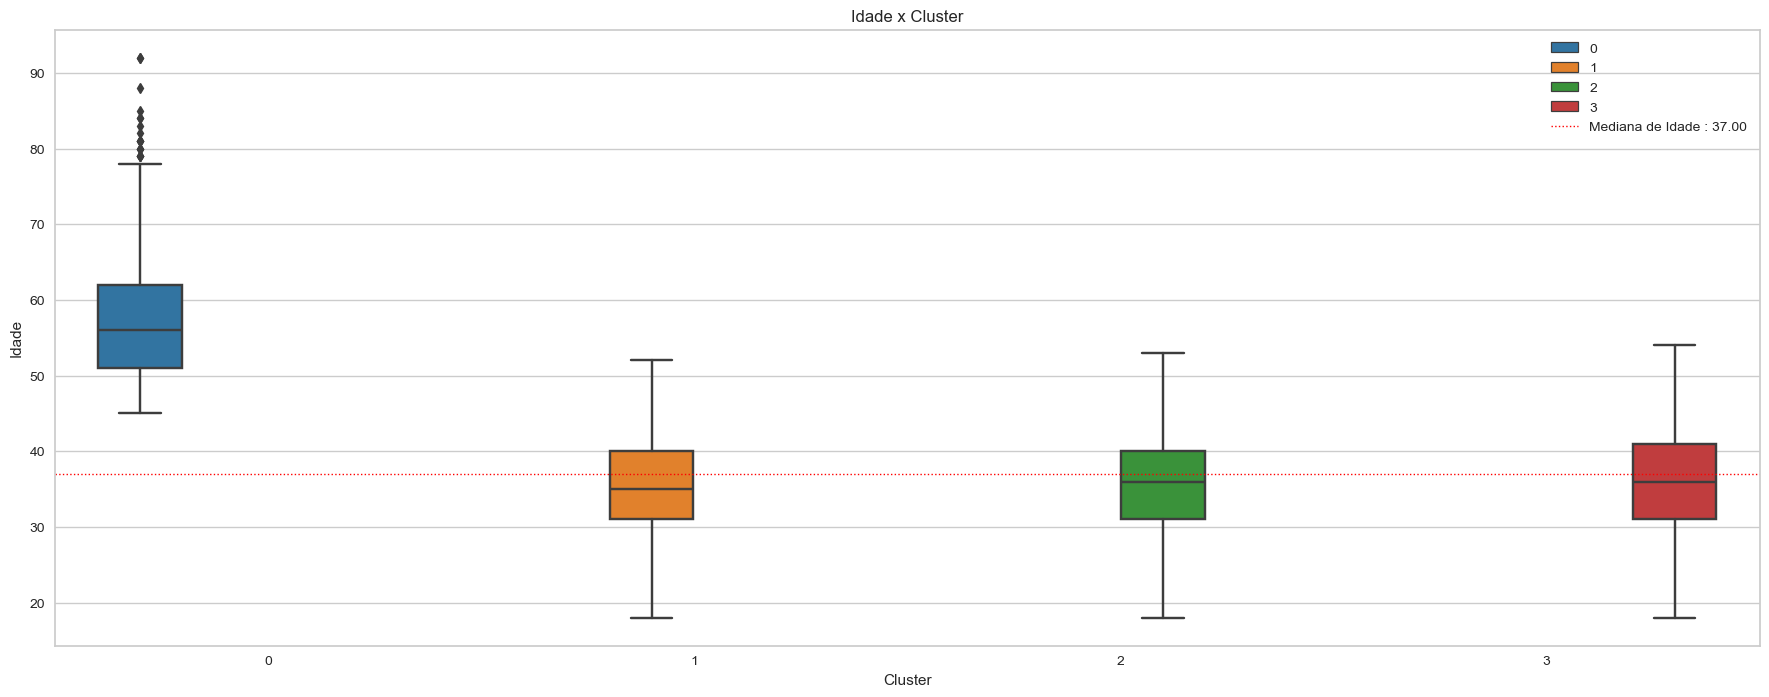

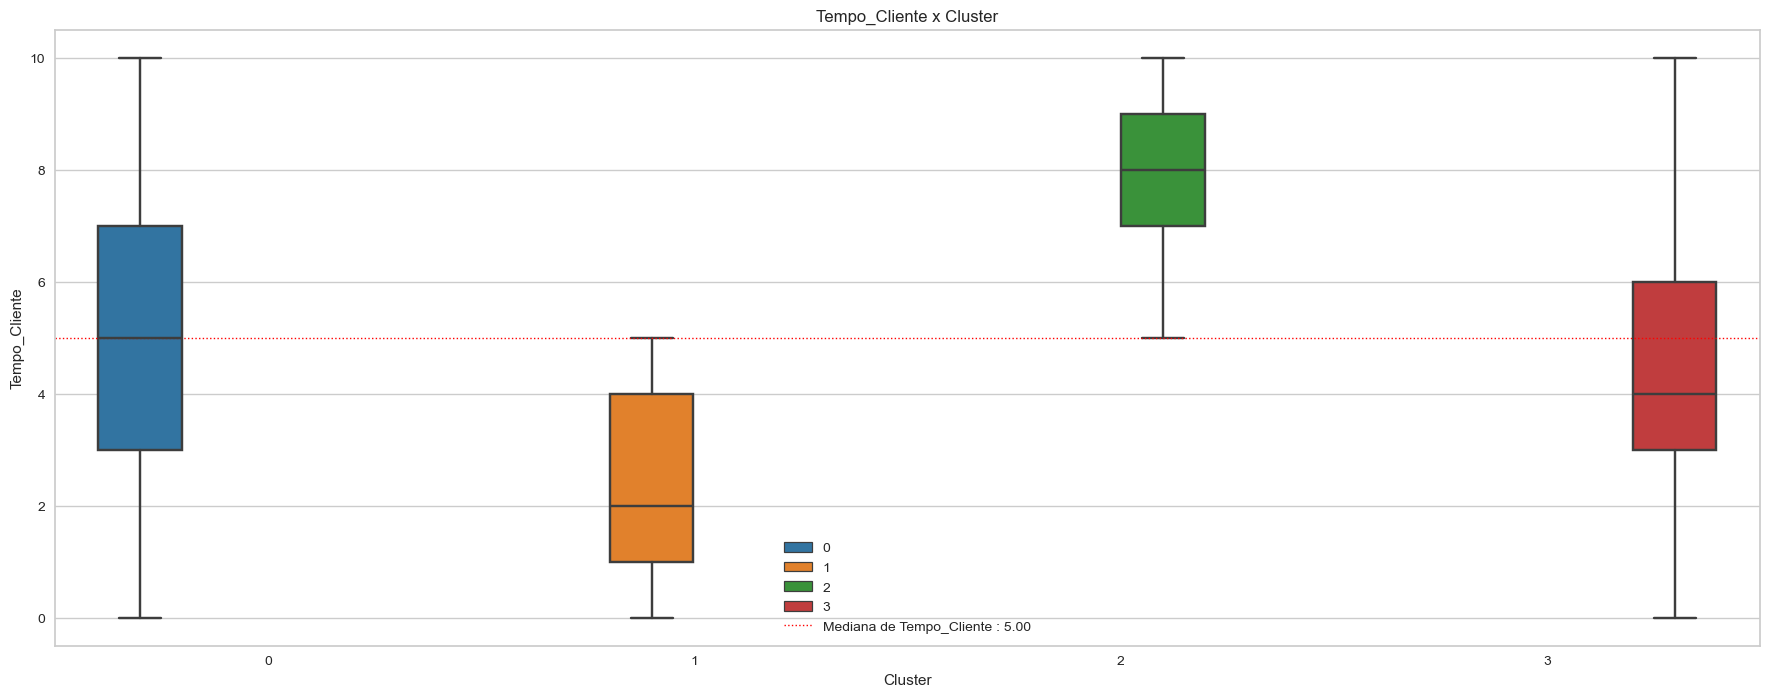

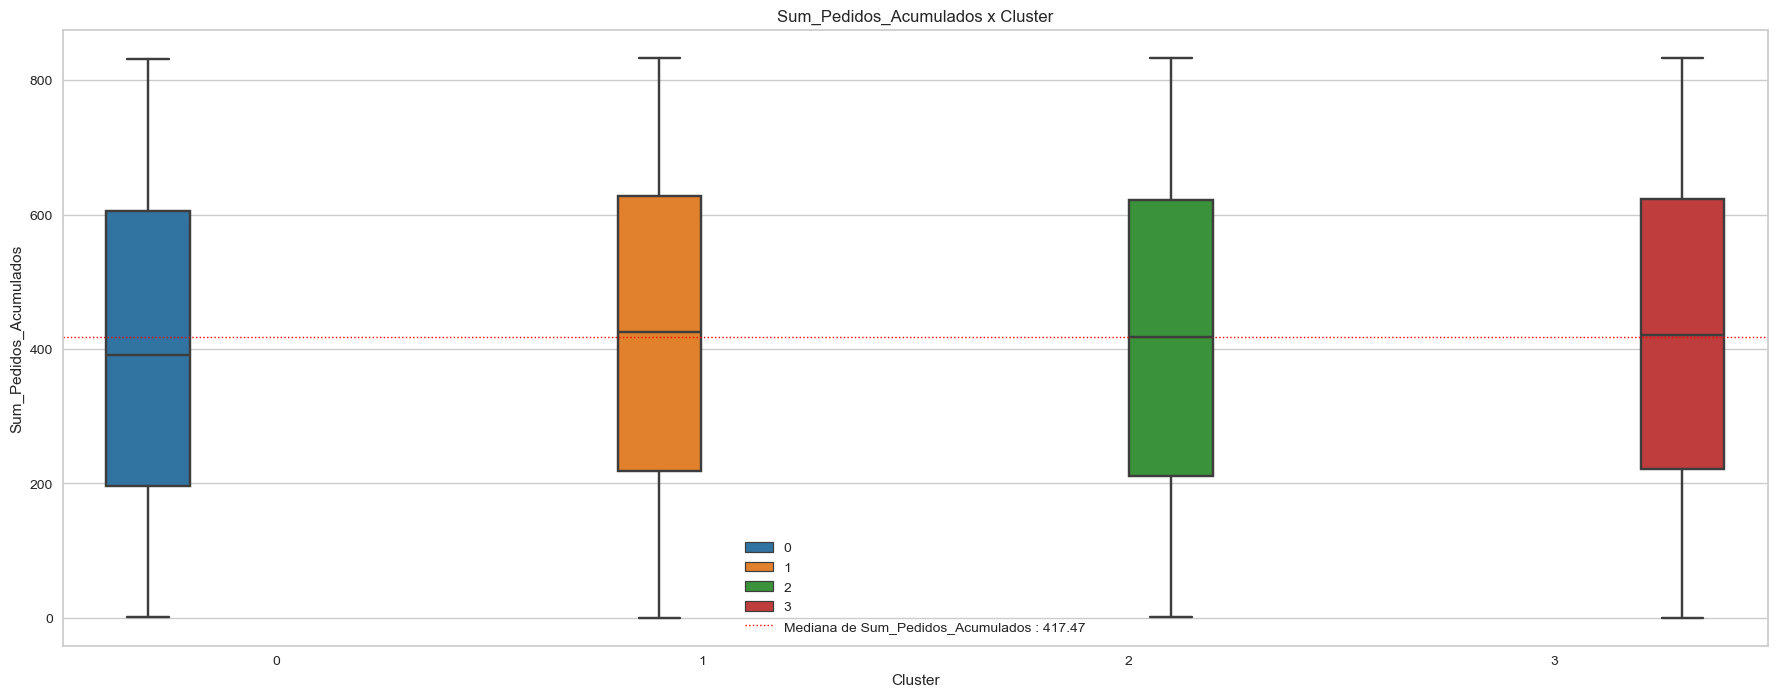

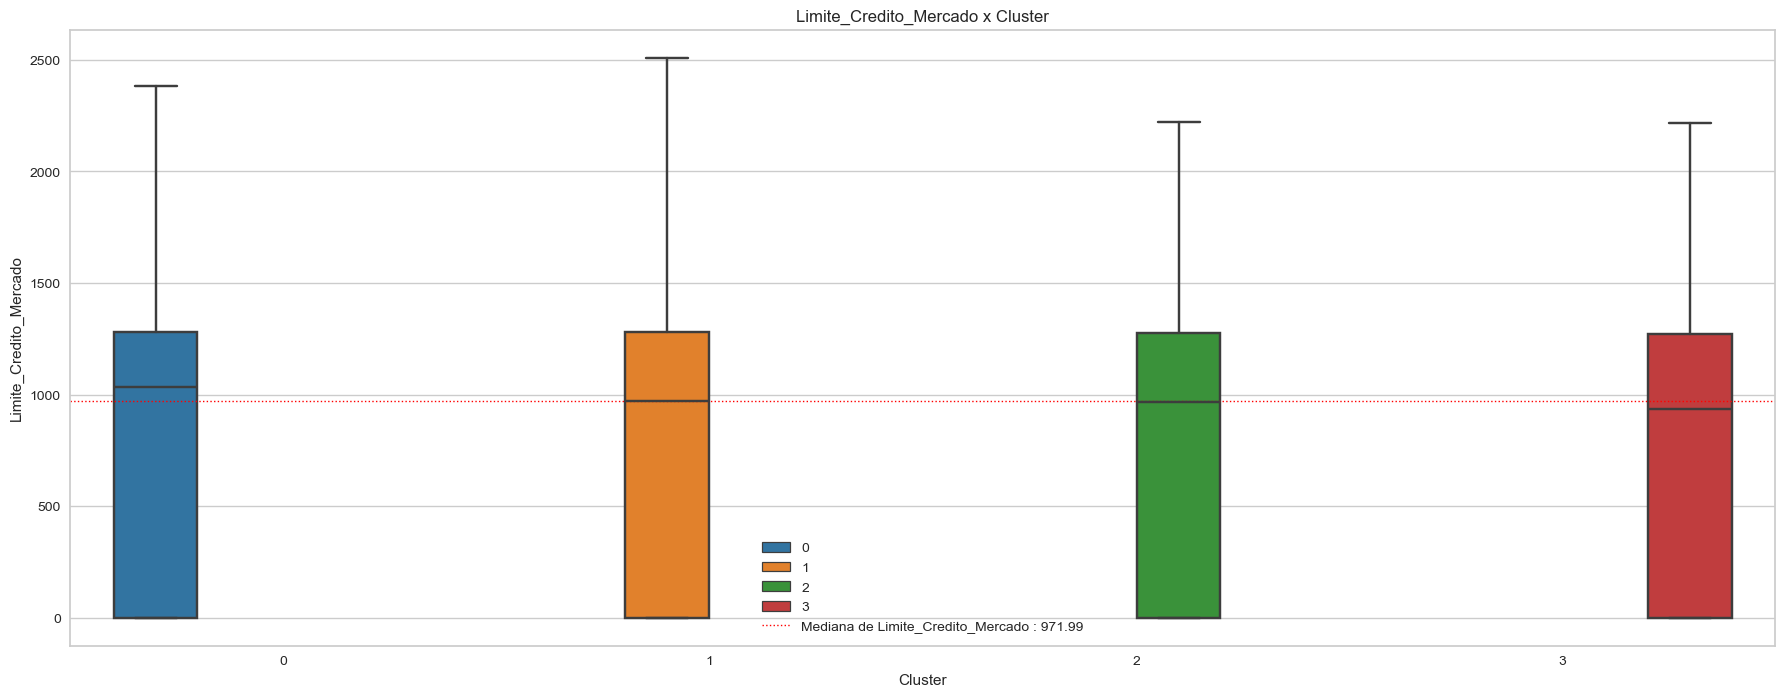

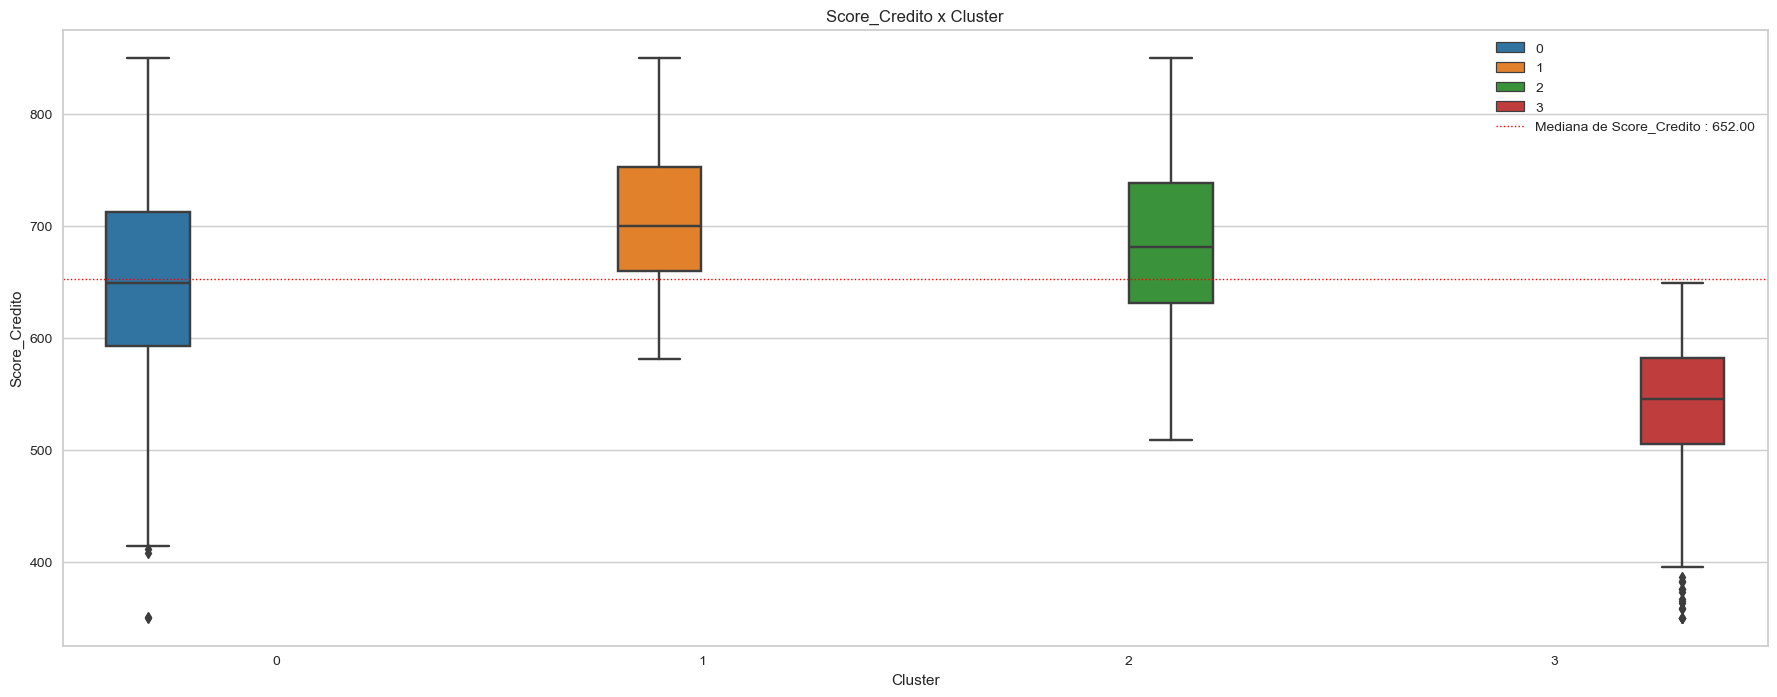

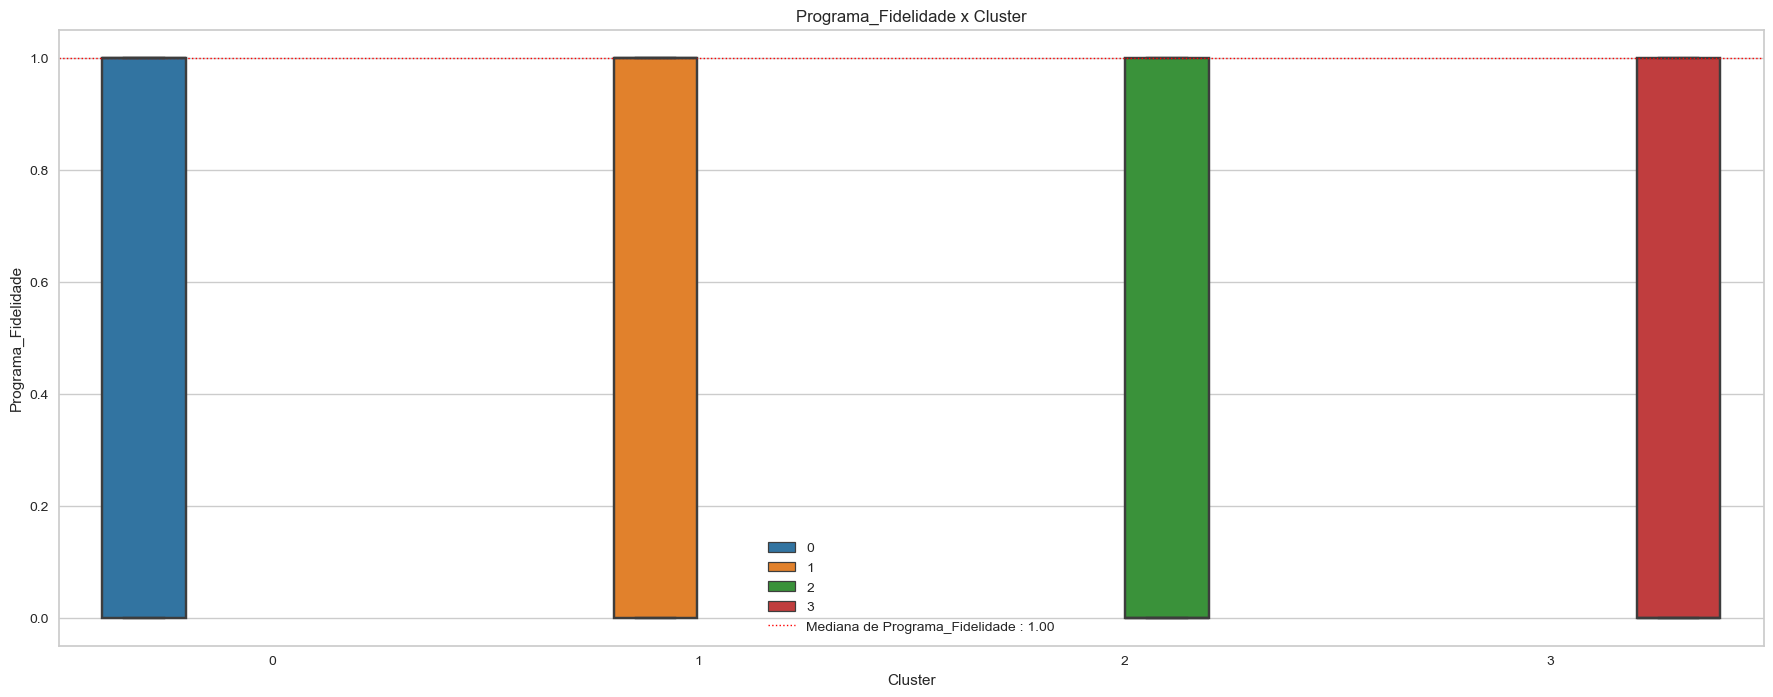

In [28]:
vars_numericas = list(set(df_churn.columns) - set(vars_categoricas) - set(['TARGET','ClientId', 'DataExtracao', 'DataUltimaTransacao', 'DiasDesdeUltTransacao','Target', 'Cluster']))
for var in vars_numericas:
  plt.figure(figsize=(22, 8))
  pl=sns.boxplot(x=df_churn["Cluster"], y=df_churn[var], palette= pal, hue=df_churn["Cluster"])

  mediana = df_churn[var].median()
  # Adicionando uma linha indicando a média da variável de rotatividade
  text = f'Mediana de {var} :'+' {:.2f}'.format(mediana)
  plt.axhline(mediana, color='red', linestyle='dotted', linewidth=1, label=text)

  pl.set_title(f"{var} x Cluster")
  plt.legend()
  plt.show()

Insights gerados:
* Limite de crédito:
  * Cluster 0 tem 50% dos clientes com limite de crédito maior (1032) do que a mediana geral (971.99);
  * Cluster 3 tem 550% dos clientes com limite de crédito menor (935) do que a mediana geral (971.99);
* Tempo cliente:
  * O cluster com maior tempo de uso do aplicativo foi cluster 2 com 50% usando até 8 meses.
  * O cluster 0 que tem maior taxa de churn, 50% dos clientes usaram até 5 meses o app.
  * Já o cluster com menor tempo de uso foi o 1, com 50% dos clientes usando em até 2 meses o app.
* Soma de pedidos:
  * O cluster 0 é o que se destaca em realção aos pedidos, sendo que 50% dos clientes gastaram 391 unidades monetárias, frente uma mediana geral de 417;
* Score Credito:
  * O cluster 3 tem o menor score de crédito, sendo que o máximo foi de 649 pontos, frente uma mediana geral de 652 pontos.
  * O cluster 0 que tem maior taxa de churn, 50% dos clientes tem um score de crédito de até 649, 3 pontos a menos do que a mediana geral.
* Idade:
  * Os clientes do cluster 0 tem entre 45 e 92 anos, sendo que a mediana geral é de 37 anos.

## Acionáveis

* Cluster 0:
   * Personalização de Comunicações e Ofertas:
     * Por exemplo, oferecer descontos em categorias de produtos que os clientes compram.
   * Programa de Fidelidade e Recompensas:
     * Implementar um programa de fidelidade que recompense os clientes por compras recorrentes e engajamento com o aplicativo. Isso pode incluir pontos de recompensa, descontos especiais ou benefícios exclusivos para clientes frequentes.
   * Campanhas de Marketing Segmentadas por Idade e Gênero:
     * Criar campanhas de marketing direcionadas especificamente para o público do cluster 0, levando em consideração a faixa etária e o equilíbrio de gênero dentro desse grupo.

In [31]:
df_aux = df_churn.query('Cluster == 0')
df_aux['Limite_Credito_Mercado'].describe()

count    1575.000000
mean      821.622830
std       608.262156
min         0.000000
25%         0.000000
50%      1032.678000
75%      1281.756900
max      2383.875600
Name: Limite_Credito_Mercado, dtype: float64

In [32]:
df_aux = df_churn.query('Cluster == 3')
df_aux['Limite_Credito_Mercado'].describe()

count    2539.000000
mean      736.018273
std       631.224229
min         0.000000
25%         0.000000
50%       935.472300
75%      1272.821750
max      2215.328000
Name: Limite_Credito_Mercado, dtype: float64

In [33]:
df_aux = df_churn.query('Cluster == 2')
df_aux['Tempo_Cliente'].describe()

count    2973.000000
mean        7.969391
std         1.307939
min         5.000000
25%         7.000000
50%         8.000000
75%         9.000000
max        10.000000
Name: Tempo_Cliente, dtype: float64

In [34]:
df_aux = df_churn.query('Cluster == 0')
df_aux['Tempo_Cliente'].describe()

count    1575.000000
mean        4.896508
std         2.740367
min         0.000000
25%         3.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tempo_Cliente, dtype: float64

In [35]:
df_aux = df_churn.query('Cluster == 0')
df_aux['Sum_Pedidos_Acumulados'].describe()

count    1575.000000
mean      403.030469
std       240.618957
min         0.382292
25%       196.383688
50%       391.020083
75%       605.496062
max       831.922917
Name: Sum_Pedidos_Acumulados, dtype: float64

In [36]:
df_aux = df_churn.query('Cluster == 3')
df_aux['Score_Credito'].describe()

count    2539.000000
mean      540.092950
std        53.284619
min       350.000000
25%       505.000000
50%       545.000000
75%       581.500000
max       649.000000
Name: Score_Credito, dtype: float64

In [37]:
df_aux = df_churn.query('Cluster == 0')
df_aux['Score_Credito'].describe()

count    1575.000000
mean      651.464762
std        90.170690
min       350.000000
25%       592.500000
50%       649.000000
75%       712.000000
max       850.000000
Name: Score_Credito, dtype: float64

In [38]:
df_aux = df_churn.query('Cluster == 0')
df_aux['Idade'].describe()

count    1575.000000
mean       57.312381
std         7.985148
min        45.000000
25%        51.000000
50%        56.000000
75%        62.000000
max        92.000000
Name: Idade, dtype: float64

In [39]:
df_churn.head()

,ClientId,DataExtracao,Score_Credito,Estado,Gênero,Idade,Tempo_Cliente,Limite_Credito_Mercado,Qte_Categorias,Usa_Cartao_Credito,Programa_Fidelidade,Sum_Pedidos_Acumulados,DataUltimaTransacao,DiasDesdeUltTransacao,Target,Cluster,TARGET
0,345568,2019-06-30,619,São Paulo,Feminino,42,2,0.0000,1,1,1,422.287000,2019-09-14,46,1,1,1
1,345569,2019-06-30,608,Rio de Janeiro,Feminino,41,1,838.0786,1,0,1,468.927417,2019-10-05,25,0,1,0
2,345570,2019-06-30,502,São Paulo,Feminino,42,8,1596.6080,3,1,0,474.714875,2019-08-20,71,1,3,1
3,345571,2019-06-30,699,São Paulo,Feminino,39,1,0.0000,2,0,0,390.944292,2019-10-21,9,0,1,0
4,345572,2019-06-30,850,Rio de Janeiro,Feminino,43,2,1255.1082,1,1,1,329.517083,2019-10-26,4,0,1,0


In [40]:
# Supondo que 'nome_do_arquivo.csv' seja o nome do arquivo CSV para salvar o DataFrame
# Substitua 'nome_do_arquivo.csv' pelo caminho e nome de arquivo desejado

df_churn.to_csv('../df_churn_com_cluster.csv', index=False)
